# Image and Multiple Bounding Boxes Augmentation for Deep Learning



In [1]:
# we will import all required libraries for this tutorial in advance

import imgaug as ia
import random
# imgaug uses matplotlib backend for displaying images
import matplotlib.pyplot as plt
%matplotlib inline
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
# imageio library will be used for image input/output
import imageio
import pandas as pd
import numpy as np
import re
import os
import glob
import shutil
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading txt annotations and converting then to dataframe of given format

**1.get the images**

In [3]:
path = '/content/drive/MyDrive/new_dataset_3'

In [4]:
image_extensions = ['.tif', '.tiff', '.bmp', '.jpg', '.jpeg', '.gif', '.png', '.eps']

In [5]:
# load images as NumPy arrays and append them to images list
images = []
for extension in image_extensions:
  for index, file in enumerate(glob.glob(path+'/*'+extension)):
    images.append(imageio.imread(file))
   
# how many images we have
print('We have {} images'.format(len(images)))

We have 64 images


**2. Convert all .txt annotations into a csv file(images with bounding box only)**

In [6]:
#generate a list [[image name,width,height,class,xmin,ymin,xmax,ymax],[],[]]

def txt_to_csv(path):
  Info_list = []
  for extension in image_extensions:
    os_specific_path = os.path.join(path,'*'+extension)
    Image_List = glob.glob(os_specific_path)
    for img in Image_List:
       #get the Width and height of the test image
       Image_Width, Image_Height = Image.open(img).size
       #get the annotation file
       annotation_file = img[:img.rindex('.')]+'.txt'
       #read each line of annotation file and store in the list
       file1 = open(annotation_file,'r')
       lines = file1.readlines() 
        
       if len(lines)!=0:
        #read each bounding box and store it..
        for line in lines: 
          temp1 = line
          templ = temp1.strip() #remove '\n'
          temp1 = temp1.split()

          class_of_bbox = int(temp1[0])
          xc_r = float(temp1[1])
          yc_r = float(temp1[2])
          wb_r = float(temp1[3])
          hb_r = float(temp1[4])

          xmin = int((xc_r - wb_r/2)*Image_Width)
          ymin = int((yc_r - hb_r/2)*Image_Height)
          xmax = int((xc_r+ wb_r/2)*Image_Width)
          ymax = int((yc_r+ hb_r/2)*Image_Height)

          #append the info into the list
          Info_list.append([img[len(path)+1:], Image_Width, Image_Height, class_of_bbox,
                            xmin, ymin, xmax, ymax])
          

  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(Info_list, columns = column_name)
  return xml_df


In [7]:
path

'/content/drive/MyDrive/new_dataset_3'

In [8]:
labels_df = txt_to_csv(path)
labels_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,103.jpeg,5489,3208,15,8,116,513,512
1,103.jpeg,5489,3208,15,501,311,868,550
2,103.jpeg,5489,3208,15,84,895,662,1234
3,103.jpeg,5489,3208,15,918,845,1407,1134
4,103.jpeg,5489,3208,15,8,1379,524,1873


In [9]:
#only those images names that has bounding box
#if some image do not have bounding box we wont consider it
labels_df['filename'].unique()

array(['103.jpeg', '101.jpeg', '105.jpeg', '106.jpeg', '107.jpeg',
       '108.jpeg', '109.jpeg', '112.jpeg', 'd3.jpeg', 'd4.jpeg',
       'd5.jpeg', 'd7.jpeg', 'd8.jpeg', 'd9.jpeg', 'd10.jpeg', 'd13.jpeg',
       'd14.jpeg', 'd15.jpeg', 'd17.jpeg', 'd18.jpeg', 'd1.jpeg',
       'd20.jpeg', '104.png', '100.png', '102.png',
       'PicsArt_08-10-10-08-13_jpg.rf.86f6f89e65e20f42da028e5efe0f1aad.png',
       'PicsArt_08-10-09-58-45_jpg.rf.331474da03fa628eec2f92113f034174.png',
       'PicsArt_08-10-09-47-05_jpg.rf.3a76f89f319e72c54d44bf5299f87f25.png',
       'PicsArt_08-10-09-38-32_jpg.rf.9919a43b66fa44f97c9f173b41cba8b6.png',
       'PicsArt_08-10-09-34-26_jpg.rf.b438435be9ac6a86487f13075fa5ee93.png',
       'd12.png', 'd6.png'], dtype=object)

## RESIZING the images that are having drones in them other images are not resized for now

**Resize the images**

In [10]:
# to resize the images we create two augmenters
# one is used when the image height is more than 600px and the other when the width is more than 600px
height_resize = iaa.Sequential([ 
    iaa.Resize({"height": 720, "width": 'keep-aspect-ratio'})
])

width_resize = iaa.Sequential([ 
    iaa.Resize({"height": 'keep-aspect-ratio', "width": 720})
])

In [11]:
# function to convert BoundingBoxesOnImage object into DataFrame
def bbs_obj_to_df(bbs_object):
#     convert BoundingBoxesOnImage object into array
    bbs_array = bbs_object.to_xyxy_array()
#     convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

In [12]:
def resize_imgaug(df, images_path, aug_images_path, image_prefix):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')    
    
    for filename in df['filename'].unique():
    #   Get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)
        
    #   The only difference between if and elif statements below is the use of height_resize and width_resize augmentors
    #   deffined previously.

    #   If image height is greater than or equal to image width 
    #   AND greater than 600px perform resizing augmentation shrinking image height to 600px.
        if group_df['height'].unique()[0] >= group_df['width'].unique()[0] and group_df['height'].unique()[0] > 600:
        #   read the image
            
            image = imageio.imread(os.path.join(images_path,filename))
        #   get bounding boxes coordinates and write into array        
            bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
        #   pass the array of bounding boxes coordinates to the imgaug library
            bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        #   apply augmentation on image and on the bounding boxes
            image_aug, bbs_aug = height_resize(image=image, bounding_boxes=bbs)
        #   write augmented image to a file
            imageio.imwrite(os.path.join(aug_images_path,image_prefix+filename), image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)        
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])
            
    #   if image width is greater than image height 
    #   AND greater than 600px perform resizing augmentation shrinking image width to 600px
        elif group_df['width'].unique()[0] > group_df['height'].unique()[0] and group_df['width'].unique()[0] > 600:
        #   read the image
           
            image = imageio.imread(os.path.join(images_path,filename))
        #   get bounding boxes coordinates and write into array        
            bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
        #   pass the array of bounding boxes coordinates to the imgaug library
            bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        #   apply augmentation on image and on the bounding boxes
            image_aug, bbs_aug = width_resize(image=image, bounding_boxes=bbs)
        #   write augmented image to a file
            imageio.imwrite(os.path.join(aug_images_path,image_prefix+filename), image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)        
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])

    #     append image info without any changes if it's height and width are both less than 600px 
        else:
           
            aug_bbs_xy = pd.concat([aug_bbs_xy, group_df])
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [ ]:
#resize the images and store the images in dest path (.txt annotations not yet stored)
#resized_images_df is what we will use for augmentation

resized_images_df = resize_imgaug(labels_df, path, '/content/drive/MyDrive/new_dataset_3', '')

## Perform image augmentations and storing only the augmented images in the aug folder

**3. Perform Augmentation on the given Image (For each image perform 8 type of augmentation)**

In [14]:
def image_aug(df, images_path, aug_images_path, image_prefix, augmentor):
    # create data frame which we're going to populate with augmented image info
    num_augmentations = len(augmentor)
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')
    
    for filename in df['filename'].unique():
    #   get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)   
    #   read the image
        image = imageio.imread(os.path.join(images_path,filename))
    #   get bounding boxes coordinates and write into array        
        bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    #   pass the array of bounding boxes coordinates to the imgaug library
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)


    #   apply each of the 8 augmentation 1 by one on the given image..
        for i in range(num_augmentations):


        #   apply augmentation on image and on the bounding boxes
          image_aug, bbs_aug = augmentor[i](image=image, bounding_boxes=bbs)


        #   disregard bounding boxes which have fallen out of image pane    
          bbs_aug = bbs_aug.remove_out_of_image()
        #   clip bounding boxes which are partially outside of image pane
          bbs_aug = bbs_aug.clip_out_of_image()
        
        #   don't perform any actions with the image if there are no bounding boxes left in it    
          if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
              pass
        
        #   otherwise continue
          else:
            #   write augmented image to a file
              imageio.imwrite(os.path.join(aug_images_path,image_prefix[i]+filename), image_aug)  
            #   create a data frame with augmented values of image width and height
              info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
              for index, _ in info_df.iterrows():
                  info_df.at[index, 'width'] = image_aug.shape[1]
                  info_df.at[index, 'height'] = image_aug.shape[0]
            #   rename filenames by adding the predifined prefix
              info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix[i]+x)
            #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
              bbs_df = bbs_obj_to_df(bbs_aug)
            #   concat all new augmented info into new data frame
              aug_df = pd.concat([info_df, bbs_df], axis=1)
            #   append rows to aug_bbs_xy data frame
              aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])            
    
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

**Augmentation Pipeline(We can change it later)**

In [15]:
# we will define 8 augmenters for each image so that we can generate 32*8 = 256 augmented images in total...

# horizontally flip  all images
hzntal_flip_aug = iaa.Sequential([ iaa.Fliplr(1.0),
        iaa.Sometimes(
        0.2,
        iaa.LinearContrast((0.75, 1.5)))
    ])

# crop some of the images by 0-10% of their height/width
crop_aug = iaa.Sequential([iaa.Crop(percent=(0, 0.1))
    ])

# - scale to 80-120% of image height/width (each axis independently)
scale_aug = iaa.Sequential([ iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
     iaa.Sometimes(
        0.2,
        iaa.LinearContrast((0.75, 1.5)))
    ])

 # - translate by -20 to +20 relative to height/width (per axis)
translate_aug = iaa.Sequential([iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})
    ])

# - rotate by -45 to +45 degrees
rotate_aug = iaa.Sequential([ iaa.Affine(rotate=(-30, 30)),
        iaa.Sometimes(
        0.2,
        iaa.LinearContrast((0.75, 1.5)))
    ])

 # - shear by -16 to +16 degrees
shear_aug = iaa.Sequential([iaa.Affine(shear=(-10, 10))
    ])

# Change brightness of images (50-150% of original value).
brightness_aug = iaa.Sequential([ iaa.Multiply((0.5, 1.5), per_channel=0.5)
    ])

#do the blurring..
blur_aug = iaa.Sequential([iaa.GaussianBlur((0, 3.0))
    ])

#Stack all augmentors in a pipeline...
Augmentors = [hzntal_flip_aug,
              crop_aug,
              scale_aug,
              translate_aug,
              rotate_aug,
              shear_aug,
              brightness_aug,
              blur_aug]

image_prefixes = ['hf_','cr_','sc_','tr_','ro_','sh_','br_','bl_']


In [19]:
# Apply augmentation to our resized_images and save files into 'aug_image_2' folder with  prefix.
# Write the updated images and bounding boxes annotations to the augmented_images_df dataframe.
path_to_aug_folder = '/content/drive/MyDrive/aug_images_dataset3'
augmented_images_df = image_aug(resized_images_df, path, path_to_aug_folder, image_prefixes, Augmentors)


## Copy all original resized images and their text annotations in to the aug folder

**4. Store the information of bounding boxes after augmentation in a dataframe**

In [92]:
# display new dataframe
np.unique(augmented_images_df['filename'].values).shape

(256,)

**5. store the original resized images + txt to the aug folder**

In [20]:
# Lastly we can copy all our previous images+txt into augmented folder.
for file in os.listdir(path):
    shutil.copy(os.path.join(path,file),os.path.join(path_to_aug_folder,file))

## Store all the annotations(old + augmented and store them in TEMP folder then copy all annotations to aug folder)

**6. Convert the final csv to yolo format and store all annotations in a TEMP folder** 

#### Create a YF1 folder in advance which will be used to store the .txt files for yolo

In [21]:
all_labels_df = pd.concat([resized_images_df, augmented_images_df])
all_labels_df.to_csv('dataset_final_1.csv', index=False)

In [22]:
grouped1 = all_labels_df.groupby('filename')

create a temp folder in advance

In [23]:
temp_folder = 'TEMP'
#Classes = {'Drone':0,'drone' :0}
uniq_files = all_labels_df['filename'].unique()
for filename in uniq_files:
  group_df = grouped1.get_group(filename)

  #This will contain the information about the bounding boxes in yolo format 
  infos = []
  #get the prefix of image 
  pos = filename.rfind('.')
  prefix = filename[:pos]+'.txt'
  #get the number of bounding boxes present in that image..
  num_bbox = group_df.shape[0]

  #for each bbox get the normalized cordinates..
  for i in range(num_bbox):
    
    #If the bounding box is not present (have some cordinates as missing we ignore it)..
    if group_df.iloc[i].isnull().any() == False:


      #get width and height
      W = group_df.iloc[i]['width']
      H = group_df.iloc[i]['height']

      #Get the numeric class of the object present in the bounding box..
      lbl =group_df.iloc[i]['class']

      #normalized center cordinates for BBoxes..
      xcen = float((group_df.iloc[i]['xmin'] + group_df.iloc[i]['xmax'])) / 2 / W
      ycen = float((group_df.iloc[i]['ymin'] + group_df.iloc[i]['ymax'])) / 2 / H

      #normalized width and height of bboxes..
      w = float((group_df.iloc[i]['xmax'] - group_df.iloc[i]['xmin'])) / W
      h = float((group_df.iloc[i]['ymax'] - group_df.iloc[i]['ymin'])) / H

      #combine all the above information into a string and add it to the list
      temp = [lbl, xcen, ycen, w, h]

      infos.append(temp)
      

  #Append all the bbox information for the given file into a .txt file..
  #create the .txt file with same name as image and store the bbox info in that
  #first item is class_id which has to be non negative integer and remaining 4 items are floats.
  txt_path = os.path.join(temp_folder, prefix)

  with open(txt_path, 'w') as f:
    #if the image has no bounding box add no entry..
    if len(infos) == 0:
      f.write("")
    else:
      for bbox_info in infos:
        for i in range(len(bbox_info)):
          item = bbox_info[i]
          if i==0:
            f.write("%d " %item)
          else:
            f.write("%f " % item)
        f.write("\n")


In [24]:
#copy all .txt annotations from TEMP folder to the aug2 folder
cur_path = '/content/TEMP'
for file in os.listdir(cur_path):
    shutil.copy(os.path.join(cur_path,file),os.path.join(path_to_aug_folder,file))

**12 Visulaizing augmentations of a sample image**

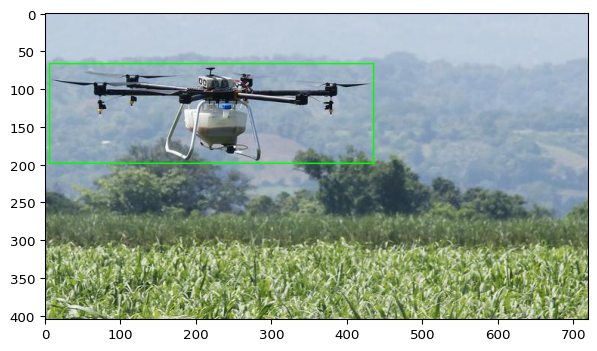

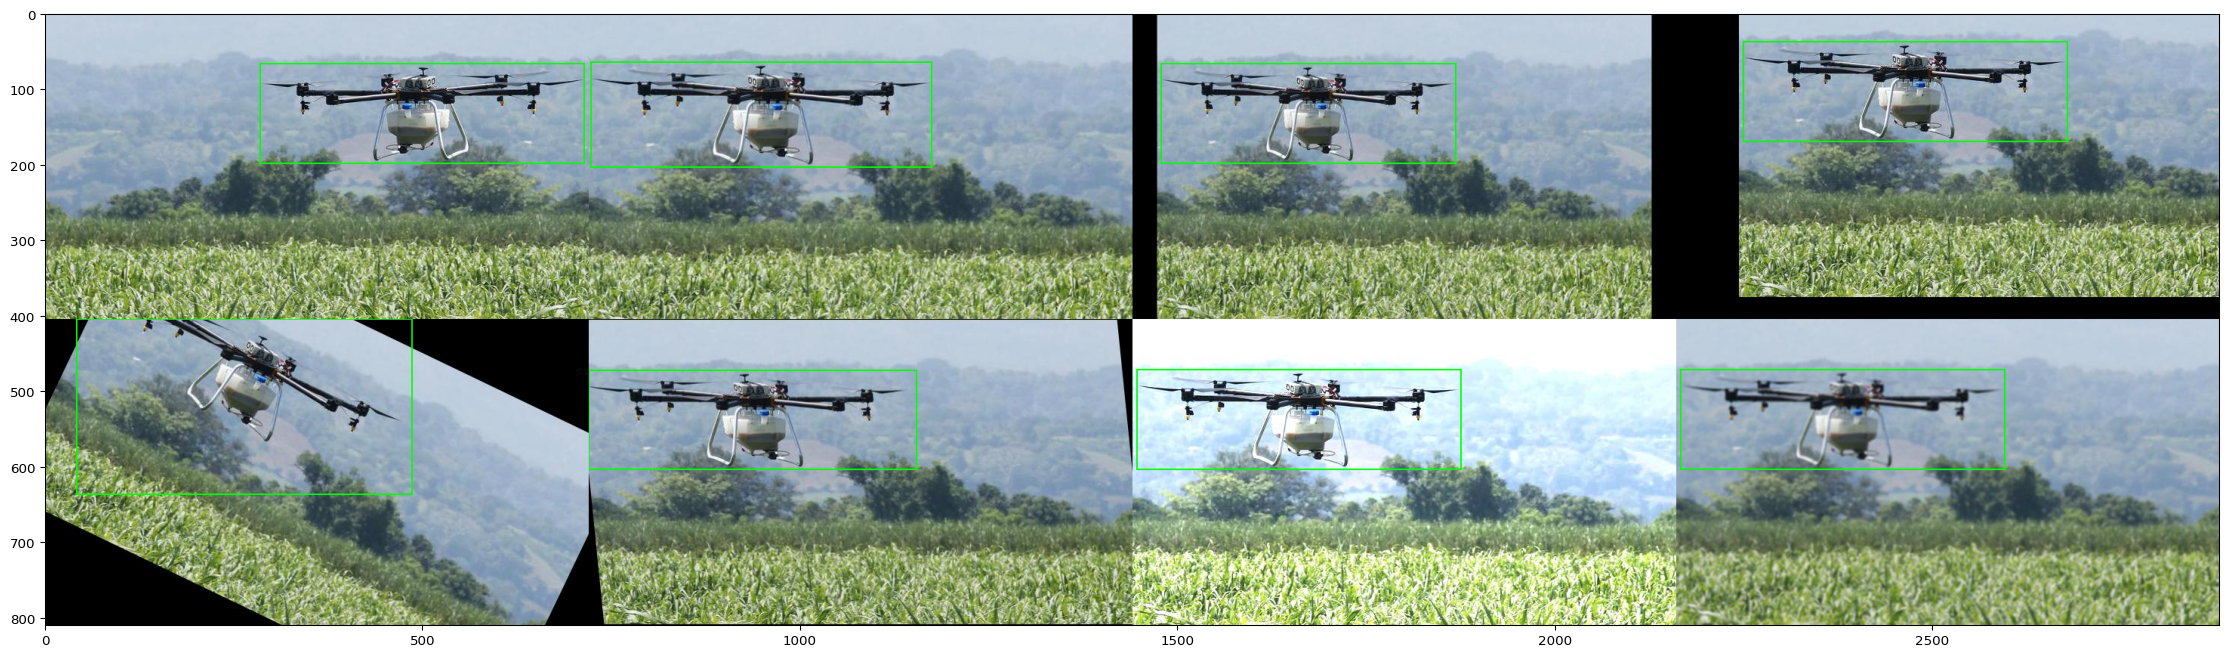

In [37]:
#Visulaization of the number of augmentations for a given image..
grouped_resized = resized_images_df.groupby('filename')
grouped_augmented = augmented_images_df.groupby('filename')

filename = resized_images_df['filename'].unique()[18]

group_r_df = grouped_resized.get_group(filename)
group_r_df = group_r_df.reset_index()
group_r_df = group_r_df.drop(['index'], axis=1)
bb_r_array = group_r_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
resized_img = imageio.imread(os.path.join(path,filename))
bbs_r = BoundingBoxesOnImage.from_xyxy_array(bb_r_array, shape=resized_img.shape)

ia.imshow(bbs_r.draw_on_image(resized_img, size=2))


lt = []
for i in range(8):
  group_a_df = grouped_augmented.get_group(image_prefixes[i]+filename)
  group_a_df = group_a_df.reset_index()
  group_a_df = group_a_df.drop(['index'], axis=1)
  bb_a_array = group_a_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
  augmented_img = imageio.imread(os.path.join(path_to_aug_folder,image_prefixes[i]+filename))
  bbs_a = BoundingBoxesOnImage.from_xyxy_array(bb_a_array, shape=augmented_img.shape)
  lt.append([bbs_a,augmented_img])

ia.imshow(np.vstack([np.hstack([
            lt[0][0].draw_on_image(lt[0][1], size=2),
            lt[1][0].draw_on_image(lt[1][1], size=2),
            lt[2][0].draw_on_image(lt[2][1], size=2),
            lt[3][0].draw_on_image(lt[3][1], size=2)
            ]),
            np.hstack([lt[4][0].draw_on_image(lt[4][1], size=2),
            lt[5][0].draw_on_image(lt[5][1], size=2),
            lt[6][0].draw_on_image(lt[6][1], size=2),
            lt[7][0].draw_on_image(lt[7][1], size=2)
            ])
]))